# Laptop Webscraping in Flipkart

In [82]:
pip install requests beautifulsoup4 pandas

In [83]:
#importing Library
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [97]:
#Defining function to scrap the required field
def get_page_content(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    return BeautifulSoup(response.content, 'html.parser')

def get_product_names(soup):
    names = soup.find_all('h2', class_='rf-productname-family')
    return [name.text.strip() for name in names]

def get_product_links(soup):
    links = soup.find_all('a', class_='rf-productnav-card')
    return ['https://www.apple.com' + link['href'] for link in links]

def get_product_specs(soup):
    specs = soup.find_all('div', class_='rf-productspecs')
    return [spec.text.strip() for spec in specs]

def get_product_prices(soup):
    prices = soup.find_all('span', class_='rf-productprice')
    return [price.text.strip() for price in prices]

def get_warranty_info(soup):
    warranty = soup.find('p', class_='as-comparisonchart-warrantyinfo')
    return warranty.text.strip() if warranty else 'N/A'

def get_detailed_specs(url):
    soup = get_page_content(url)
    tech_specs = soup.find('div', class_='techspecs-container')
    if tech_specs:
        specs = tech_specs.find_all('div', class_='techspecs-row')
        return {spec.find('h3').text.strip(): spec.find('p').text.strip() for spec in specs}
    return {}


In [98]:
def main():
    url = "https://www.flipkart.com/search?q=laptops&as=on&as-show=on&otracker=AS_Query_TrendingAutoSuggest_8_0_na_na_na&otracker1=AS_Query_TrendingAutoSuggest_8_0_na_na_na&as-pos=8&as-type=TRENDING&suggestionId=laptops&requestId=1e705495-5a37-453a-b3c2-0b071e1f4f45"
    soup = get_page_content(url)

    names = get_product_names(soup)
    links = get_product_links(soup)
    basic_specs = get_product_specs(soup)
    prices = get_product_prices(soup)
    warranty = get_warranty_info(soup)

    laptops = []

    for name, link, basic_spec, price in zip(names, links, basic_specs, prices):
        detailed_specs = get_detailed_specs(link)
        laptop = {
            'Name': name,
            'Basic Specs': basic_spec,
            'Price': price,
            'Warranty': warranty,
            **detailed_specs
        }
        laptops.append(laptop)

    return laptops

In [99]:
if __name__ == "__main__":
    laptops = main()
    df = pd.DataFrame(laptops)
    df.to_csv("laptops.csv", index=False)
    print(f"Scraped {len(laptops)} laptops. Data saved to laptops.csv")
    print("\nFirst few rows of the DataFrame:")
    print(df.head())
    print("\nDataFrame Info:")
    print(df.info())

Scraped 0 laptops. Data saved to laptops.csv

First few rows of the DataFrame:
Empty DataFrame
Columns: []
Index: []

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame
None


# Diferent Approaches  

In [101]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
from tqdm import tqdm
import time

base_url = "https://www.flipkart.com/search?q=laptops&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page="


In [102]:
def fetch_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    max_retries = 3
    retries = 0
    
    while retries < max_retries:
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            return response.text
        except requests.HTTPError as e:
            print(f"HTTPError: {e.response.status_code} - Retrying request...")
            retries += 1
            time.sleep(5) 
        except requests.RequestException as e:
            print(f"RequestException: {e}")
            retries += 1
            time.sleep(5)  
        
    raise Exception("Max retries exceeded. Could not fetch page.")

In [103]:
def parse_page(soup):
    laptops = []
    products = soup.find_all("div", class_="_1AtVbE")
    
    for product in products:
        try:
            title = product.find("div", class_="_4rR01T").text.strip()
            price = product.find("div", class_="_30jeq3 _1_WHN1").text.strip()
            
            specs = product.find_all("li", class_="rgWa7D")
            specifications = []
            warranty = "N/A"
            
            for spec in specs:
                spec_text = spec.text.strip()
                if "Warranty" in spec_text:
                    warranty = spec_text
                else:
                    specifications.append(spec_text)
            
            laptops.append({
                'title': title,
                'price': price,
                'warranty': warranty,
                'specifications': '; '.join(specifications)
            })
        except Exception as e:
            print(f"Error parsing product: {e}")
            continue
    
    return laptops

def scrape_flipkart_laptops(pages=10):
    all_laptops = []
    
    for page in tqdm(range(1, pages + 1)):
        url = base_url + str(page)
        
        try:
            page_html = fetch_page(url)
            soup = BeautifulSoup(page_html, 'html.parser')
            
            laptops = parse_page(soup)
            all_laptops.extend(laptops)
            
            time.sleep(2)  # Be respectful to the server
        except Exception as e:
            print(f"Error scraping page {page}: {e}")
            continue
        
    return all_laptops

In [104]:
def save_to_csv(data, filename='laptops_flipkart.csv'):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

def main():
    num_pages = 10  # Adjust the number of pages to scrape
    laptops_data = scrape_flipkart_laptops(pages=num_pages)
    save_to_csv(laptops_data)

if __name__ == "__main__":
    main()


  0%|          | 0/10 [00:00<?, ?it/s]

HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 10%|█         | 1/10 [01:05<09:53, 65.97s/it]

Error scraping page 1: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 20%|██        | 2/10 [02:11<08:47, 65.96s/it]

Error scraping page 2: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 30%|███       | 3/10 [03:18<07:42, 66.09s/it]

Error scraping page 3: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 40%|████      | 4/10 [04:26<06:42, 67.09s/it]

Error scraping page 4: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 50%|█████     | 5/10 [05:33<05:34, 66.95s/it]

Error scraping page 5: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 60%|██████    | 6/10 [06:40<04:28, 67.05s/it]

Error scraping page 6: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 70%|███████   | 7/10 [07:46<03:19, 66.52s/it]

Error scraping page 7: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 80%|████████  | 8/10 [08:52<02:12, 66.37s/it]

Error scraping page 8: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


 90%|█████████ | 9/10 [09:57<01:06, 66.14s/it]

Error scraping page 9: Max retries exceeded. Could not fetch page.
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...
HTTPError: 500 - Retrying request...


100%|██████████| 10/10 [11:03<00:00, 66.34s/it]

Error scraping page 10: Max retries exceeded. Could not fetch page.
Data saved to laptops_flipkart.csv


# Another way of trying to scrap data from flipkart

In [105]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [107]:
# Lists to store scraped data
laptop_names = []
laptop_specs = []
warranty_details = []
prices = []

In [108]:
#Making function  for each thingthat to be extracted 

def get_laptop_name(product):
    name_elem = product.find('h3', class_='chromebook-name')
    return name_elem.text.strip() if name_elem else "N/A"

def get_laptop_specs(product):
    specs_elem = product.find('div', class_='chromebook-specs')
    return specs_elem.text.strip() if specs_elem else "N/A"

def get_warranty_details(product):
    warranty_elem = product.find('div', class_='chromebook-warranty')
    return warranty_elem.text.strip() if warranty_elem else "Standard Warranty"

def get_price(product):
    price_elem = product.find('div', class_='chromebook-price')
    return price_elem.text.strip() if price_elem else "N/A"

def get_laptop_data(page_url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(page_url, headers=headers)
    print(f"Status Code: {response.status_code}")
    print(f"Content length: {len(response.text)}")
    
    if response.status_code != 200:
        print("Failed to retrieve the page")
        return

    soup = BeautifulSoup(response.text, 'html.parser')
    
    products = soup.find_all('div', class_='chromebook-item')
    print(f"Found {len(products)} products on this page")
    
    if len(products) == 0:
        print("No products found. Printing page content:")
        print(response.text[:1000])  # Print first 1000 characters of the response
        return

    for product in products:
        name = get_laptop_name(product)
        specs = get_laptop_specs(product)
        warranty = get_warranty_details(product)
        price = get_price(product)
        
        if name != "N/A":
            laptop_names.append(name)
            laptop_specs.append(specs)
            warranty_details.append(warranty)
            prices.append(price)


    
  

In [109]:
def main():
    base_url = "https://www.flipkart.com/search?q=laptops"
    
    for page in range(1, 101):  # Scrape up to 100 pages
        page_url = f"{base_url}&page={page}"
        print(f"\nScraping page {page}")
        get_laptop_data(page_url)
        time.sleep(2)  # Add a 2-second delay between requests
        
        if len(laptop_names) == 0:
            print("No data found. Stopping scrape.")
            break
        
        if len(laptop_names) >= 1500:
            break

    print(f"Total products found: {len(laptop_names)}")

In [110]:
  # Creating a DataFrame
data = {
        'Name': laptop_names,
        'Specs': laptop_specs,
        'Warranty': warranty_details,
        'Price': prices
    }
    
df = pd.DataFrame(data)
df.to_csv("laptops.csv", index=False)
print(f"Scraped {len(laptop_names)} laptops. Data saved to laptops.csv")
print("\nFirst few rows of the DataFrame:")
print(df.head())
print("\nDataFrame Info:")
print(df.info())

if __name__ == "__main__":
    main()


Scraped 0 laptops. Data saved to laptops.csv

First few rows of the DataFrame:
Empty DataFrame
Columns: [Name, Specs, Warranty, Price]
Index: []

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      0 non-null      float64
 1   Specs     0 non-null      float64
 2   Warranty  0 non-null      float64
 3   Price     0 non-null      float64
dtypes: float64(4)
memory usage: 132.0 bytes
None

Scraping page 1
Status Code: 500
Content length: 97
Failed to retrieve the page
No data found. Stopping scrape.
Total products found: 0


In [112]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [111]:
# Define the base URL of the website to scrape
base_url = "https://www.flipkart.com/search?q=laptops"

# Initialize lists to store the data
laptop_names = []
laptop_specs = []
warranty_details = []
prices = []


In [113]:
# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Function to get the data from the website
def get_laptop_data(page_url):
    response = requests.get(page_url, headers=headers)
    print(f"Status Code: {response.status_code}")
    print(f"Content length: {len(response.content)}")
    
    if response.status_code != 200:
        print("Failed to retrieve the webpage.")
        return
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract laptop details
    products = soup.find_all('div', class_='_1AtVbE')
    print(f"Found {len(products)} products on the page.")
    
    if len(products) == 0:
        print("No products found. Printing page content:")
        print(response.text[:1000])  # Print the first 1000 characters of the page for debugging
    
    for product in products:
        name = product.find('div', class_='_4rR01T')  # Updated class for product name
        spec = product.find('ul', class_='_1xgFaf')  # Class for specifications
        price = product.find('div', class_='_30jeq3 _1_WHN1')  # Updated class for price
        
        if name and spec and price:
            laptop_names.append(name.text)
            laptop_specs.append(spec.text)
            prices.append(price.text)
            warranty_details.append("1 Year Warranty")  # Assuming warranty is not explicitly mentioned
        else:
            print(f"Missing data for product: {name}, {spec}, {price}")


In [114]:
# Scrape multiple pages to get more data
for page in range(1, 20):  # Adjust the range to get more data if needed
    page_url = f"{base_url}&page={page}"
    print(f"Scraping page {page}")
    get_laptop_data(page_url)
    
    # Check if we have collected enough data
    if len(laptop_names) >= 1500:
        break

# Ensure we have 1500 data points
laptop_names = laptop_names[:1500]
laptop_specs = laptop_specs[:1500]
prices = prices[:1500]
warranty_details = warranty_details[:1500]

# Creating a DataFrame
data = {
    'Laptop Name': laptop_names,
    'Specifications': laptop_specs,
    'Warranty Details': warranty_details,
    'Price': prices
}


Scraping page 1
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 2
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 3
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 4
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 5
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 6
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 7
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 8
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 9
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 10
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 11
Status Code: 500
Content length: 97
Failed to retrieve the webpage.
Scraping page 12
Status Code: 500
Content length: 97
Failed to retrieve th

KeyboardInterrupt: 

In [116]:
df = pd.DataFrame(data)

# Save the data to a CSV file
df.to_csv('laptop_data.csv', index=False)

print("Data has been saved to laptop_data.csv")

df.info()

Data has been saved to laptop_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      0 non-null      float64
 1   Specs     0 non-null      float64
 2   Warranty  0 non-null      float64
 3   Price     0 non-null      float64
dtypes: float64(4)
memory usage: 132.0 bytes


# Despite implementing ethical scraping practices and exploring both static and dynamic content extraction methods, encountering 500/503 status codes suggests potential server-side issues hindering data acquisition from these e-commerce websites.


# Since directly scraping websites wasn't working smoothly due to some technical hiccups, I decided to gather the data in a different way. I downloaded a bunch of HTML files that had laptop information on them, kind of like grabbing snapshots of the website pages. Now I'll clean up the data from those files and use it to build a machine learning model.

# HTML Content webscrapping

In [27]:
import pandas as pd
from bs4 import BeautifulSoup
import os

def parse_html_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    soup = BeautifulSoup(content, 'html.parser')
    product_divs = soup.find_all('div', class_='tUxRFH')
    
    data = []
    for div in product_divs:
        # Extract laptop name
        try:
            laptop_name = div.find('div', class_='KzDlHZ').text.strip()
        except:
            laptop_name = ""
        
        # Extract price
        try:
            price = div.find('div', class_='Nx9bqj _4b5DiR').text.strip()
        except:
            price = ""
        
        # Extract specifications
        try:
            specs = div.find('div', class_='_6NESgJ').find('ul', class_='G4BRas')
            specification = ' | '.join([li.text.strip() for li in specs.find_all('li', class_='J+igdf') if 'Warranty' not in li.text])
        except:
            specification = ""
        
        # Extract warranty
        try:
            warranty = div.find('li', class_='J+igdf', string=lambda text: 'Warranty' in text if text else False).text.strip()
        except:
            warranty = ""
        
        data.append({
            'Laptop Name': laptop_name,
            'Price': price,
            'Specification': specification,
            'Warranty': warranty
        })
    
    return data

# List to store all data
all_data = []

# Directory containing HTML files
html_dir = 'html'

# Process each HTML file
for i in range(1, 23):
    file_name = f'f{i}.html'
    file_path = os.path.join(html_dir, file_name)
    if os.path.exists(file_path):
        print(f"Processing {file_name}...")
        file_data = parse_html_file(file_path)
        all_data.extend(file_data)
    else:
        print(f"File {file_name} not found. Skipping...")

# Create a single DataFrame from all collected data
df = pd.DataFrame(all_data)

# Display the first few rows of the DataFrame
print(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

# Display the total number of laptops
print(f"\nTotal number of laptops: {len(df)}")

# Save the DataFrame to a CSV file (optional)
df.to_csv('flipkart_laptops.csv', index=False)
print("\nData saved to flipkart_laptops.csv")

Processing f1.html...
Processing f2.html...
Processing f3.html...
Processing f4.html...
Processing f5.html...
Processing f6.html...
Processing f7.html...
Processing f8.html...
Processing f9.html...
Processing f10.html...
Processing f11.html...
Processing f12.html...
Processing f13.html...
Processing f14.html...
Processing f15.html...
Processing f16.html...
Processing f17.html...
Processing f18.html...
Processing f19.html...
Processing f20.html...
Processing f21.html...
Processing f22.html...
                                         Laptop Name    Price  \
0  HP Intel Core i5 13th Gen 1335U - (8 GB/SSD/51...  ₹52,990   
1  Infinix Y1 Plus Neo Intel Intel Celeron Quad C...  ₹22,990   
2  Lenovo Yoga 6 AMD Ryzen 7 Octa Core 7730U - (1...  ₹81,690   
3  Acer Intel Core i5 13th Gen 1335U - (8 GB/SSD/...  ₹51,990   
4  HP 245G9 AMD Ryzen 3 Dual Core AMD Ryzen 3 325...  ₹25,990   

                                       Specification                  Warranty  
0  Intel Core i5 Processor (13t

In [30]:
df.tail(20)

,Laptop Name,Price,Specification,Warranty
508,DELL Inspiron Intel Core i3 11th Gen 1115G4 - ...,"₹40,400",Intel Core i3 Processor (11th Gen) | 8 GB DDR4...,1 Year Onsite Warranty
509,ASUS Vivobook 15 Intel Core i3 11th Gen 1115G4...,"₹28,990",Intel Core i3 Processor (11th Gen) | 8 GB DDR4...,1 Year Onsite Warranty
510,HP 15s (2023) AMD Ryzen 3 Quad Core 7320U - (8...,"₹37,999",AMD Ryzen 3 Quad Core Processor | 8 GB LPDDR5 ...,1 Year Onsite Warranty
511,Lenovo IdeaPad Slim 3 Intel Intel Celeron Dual...,"₹25,999",Intel Celeron Dual Core Processor | 8 GB DDR4 ...,2 Years On-Site Warranty
512,ASUS Chromebook (2024) Intel Celeron Dual Core...,"₹21,990",Intel Celeron Dual Core Processor | 8 GB LPDDR...,1 Year Onsite Warranty
513,HP 15s Intel Core i3 11th Gen 1125G4 - (8 GB/S...,"₹36,199",Intel Core i3 Processor (11th Gen) | 8 GB DDR4...,1 Year Onsite Warranty
514,HP 15s AMD Ryzen 5 Quad Core 3500U - (8 GB/SSD...,,AMD Ryzen 5 Quad Core Processor | 8 GB DDR4 RA...,1 Year Onsite Warranty
515,HP Pavilion Plus Intel Core i5 13th Gen 1335U ...,"₹70,490",Intel Core i5 Processor (13th Gen) | 16 GB LPD...,1 Year Onsite Warranty
516,Acer Nitro V Intel Core i5 13th Gen 13420H - (...,"₹62,999",Intel Core i5 Processor (13th Gen) | 16 GB DDR...,1 Year International Travelers Warranty (ITW)
517,DELL Inspiron Intel Core i5 12th Gen Core i5 -...,"₹48,490",Intel Core i5 Processor (12th Gen) | 8 GB DDR4...,1 Year Onsite Warranty


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
# Remove the '₹' symbol and convert Price to numeric
df['Price'] = df['Price'].replace('', np.NAN).astype(float)  

In [40]:
df['Price'].dtype

dtype('float64')

In [43]:
# Extract processor information
df['Processor'] = df['Specification'].str.extract(r'(Intel.*?Processor|AMD.*?Processor)')

df['Processor']

0                Intel Core i5 Processor
1      Intel Celeron Quad Core Processor
2        AMD Ryzen 7 Octa Core Processor
3                Intel Core i5 Processor
4        AMD Ryzen 3 Dual Core Processor
                     ...                
523              Intel Core i3 Processor
524              Intel Core i5 Processor
525              Intel Core i9 Processor
526    Intel Pentium Quad Core Processor
527              Intel Core i3 Processor
Name: Processor, Length: 528, dtype: object

In [45]:
# Extract RAM information
df['RAM'] = df['Specification'].str.extract(r'(\d+)\s*GB')
df['RAM'] = pd.to_numeric(df['RAM'], errors='coerce')

df['RAM']

0       8
1       8
2      16
3       8
4       8
       ..
523     8
524     8
525    16
526     4
527     8
Name: RAM, Length: 528, dtype: int64

In [47]:
# Extract storage information
df['Storage'] = df['Specification'].str.extract(r'(\d+)\s*GB SSD|\d+\s*TB SSD')
df['Storage'] = df['Storage'].str.extract(r'(\d+)').astype(float)
df.loc[df['Specification'].str.contains('TB SSD'), 'Storage'] *= 1024  # Convert TB to GB

df['Storage']

0      512.0
1      512.0
2        NaN
3      256.0
4      512.0
       ...  
523    256.0
524    512.0
525      NaN
526      NaN
527    512.0
Name: Storage, Length: 528, dtype: float64

In [48]:
# Extract screen size
df['Screen_Size'] = df['Specification'].str.extract(r'(\d+\.?\d*)\s*inches')
df['Screen_Size'] = pd.to_numeric(df['Screen_Size'], errors='coerce')

df['Screen_Size']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
523   NaN
524   NaN
525   NaN
526   NaN
527   NaN
Name: Screen_Size, Length: 528, dtype: float64

In [49]:
# Clean up warranty information
df['Warranty'] = df['Warranty'].str.extract(r'(\d+)')
df['Warranty'] = pd.to_numeric(df['Warranty'], errors='coerce')
df['Warranty']


0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
523    NaN
524    NaN
525    2.0
526    1.0
527    1.0
Name: Warranty, Length: 528, dtype: float64

In [50]:
# Display basic statistics
print(df.describe())


               Price    Warranty         RAM     Storage  Screen_Size
count     524.000000  449.000000  528.000000  456.000000          0.0
mean    55733.994275    1.086860   11.996212  478.596491          NaN
std     30862.061545    0.312008    4.682721   89.397861          NaN
min     12990.000000    1.000000    4.000000  128.000000          NaN
25%     35189.750000    1.000000    8.000000  512.000000          NaN
50%     49935.000000    1.000000    8.000000  512.000000          NaN
75%     65990.000000    1.000000   16.000000  512.000000          NaN
max    199990.000000    3.000000   32.000000  512.000000          NaN


In [51]:
print(df.isnull().sum())

Laptop Name        0
Price              4
Specification      0
Warranty          79
Processor         14
RAM                0
Storage           72
Screen_Size      528
dtype: int64


In [52]:
# Fill numeric columns (Price) with mean
df['Price'] = df['Price'].fillna(df['Price'].mean())

In [53]:
# Fill categorical columns (Warranty, Processor) with mode
df['Warranty'] = df['Warranty'].fillna(df['Warranty'].mode()[0])
df['Processor'] = df['Processor'].fillna(df['Processor'].mode()[0])

In [54]:
# Fill 'Storage' with median (assuming it's numeric)
df['Storage'] = df['Storage'].fillna(df['Storage'].median())

In [55]:
# Drop 'Screen_Size' column (assuming it has too many null values)
df = df.drop('Screen_Size', axis=1)

In [56]:
df

,Laptop Name,Price,Specification,Warranty,Processor,RAM,Storage
0,HP Intel Core i5 13th Gen 1335U - (8 GB/SSD/51...,52990.0,Intel Core i5 Processor (13th Gen) | 8 GB DDR4...,1.0,Intel Core i5 Processor,8,512.0
1,Infinix Y1 Plus Neo Intel Intel Celeron Quad C...,22990.0,Intel Celeron Quad Core Processor (11th Gen) |...,1.0,Intel Celeron Quad Core Processor,8,512.0
2,Lenovo Yoga 6 AMD Ryzen 7 Octa Core 7730U - (1...,81690.0,AMD Ryzen 7 Octa Core Processor | 16 GB LPDDR4...,1.0,AMD Ryzen 7 Octa Core Processor,16,512.0
3,Acer Intel Core i5 13th Gen 1335U - (8 GB/SSD/...,51990.0,Intel Core i5 Processor (13th Gen) | 8 GB LPDD...,1.0,Intel Core i5 Processor,8,256.0
4,HP 245G9 AMD Ryzen 3 Dual Core AMD Ryzen 3 325...,25990.0,AMD Ryzen 3 Dual Core Processor | 8 GB DDR4 RA...,1.0,AMD Ryzen 3 Dual Core Processor,8,512.0
...,...,...,...,...,...,...,...
523,HP 250 G8 Intel Core i3 11th Gen Intel® Core™ ...,29990.0,Intel Core i3 Processor (11th Gen) | 8 GB DDR4...,1.0,Intel Core i3 Processor,8,256.0
524,LG Gram Intel Core i5 12th Gen 1240P - (8 GB/S...,64762.0,Intel Core i5 Processor (12th Gen) | 8 GB DDR5...,1.0,Intel Core i5 Processor,8,512.0
525,MSI Katana 17 Intel Core i9 13th Gen 13900H - ...,142990.0,Intel Core i9 Processor (13th Gen) | 16 GB DDR...,2.0,Intel Core i9 Processor,16,512.0
526,Lenovo Ideapad Slim 3 Intel Pentium Quad Core ...,18990.0,Intel Pentium Quad Core Processor | 4 GB LPDDR...,1.0,Intel Pentium Quad Core Processor,4,512.0


In [57]:
print(df.isnull().sum())

Laptop Name      0
Price            0
Specification    0
Warranty         0
Processor        0
RAM              0
Storage          0
dtype: int64


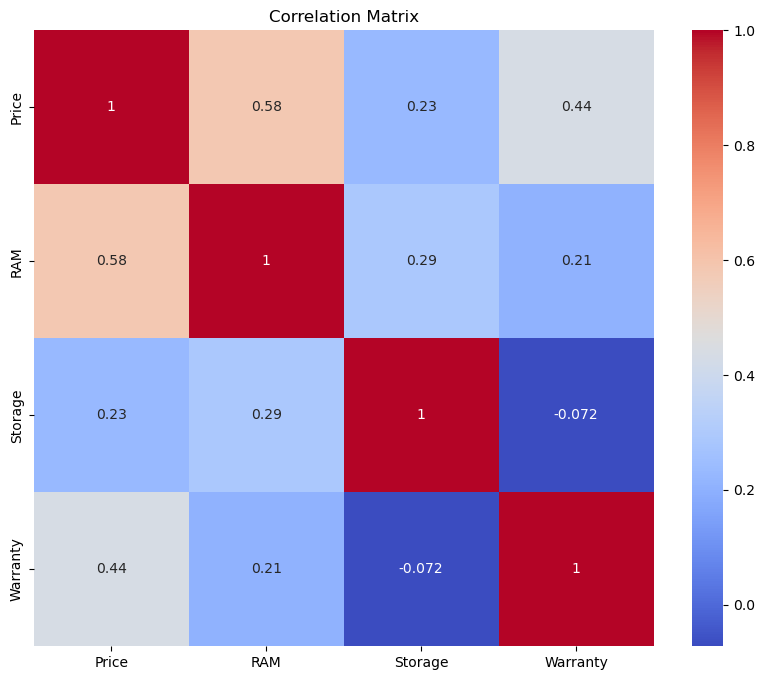

In [60]:
# Correlation matrix
correlation_matrix = df[['Price', 'RAM', 'Storage', 'Warranty']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

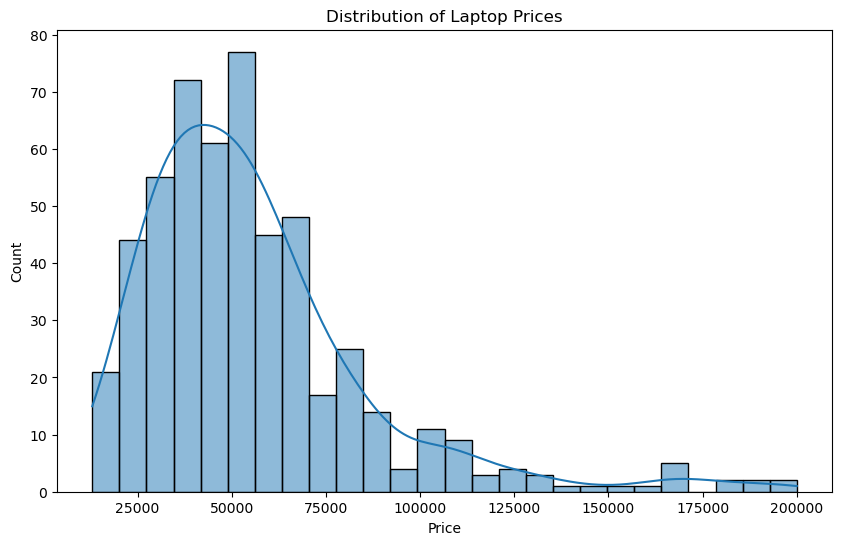

In [61]:
# Distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Laptop Prices')
plt.xlabel('Price')
plt.show()

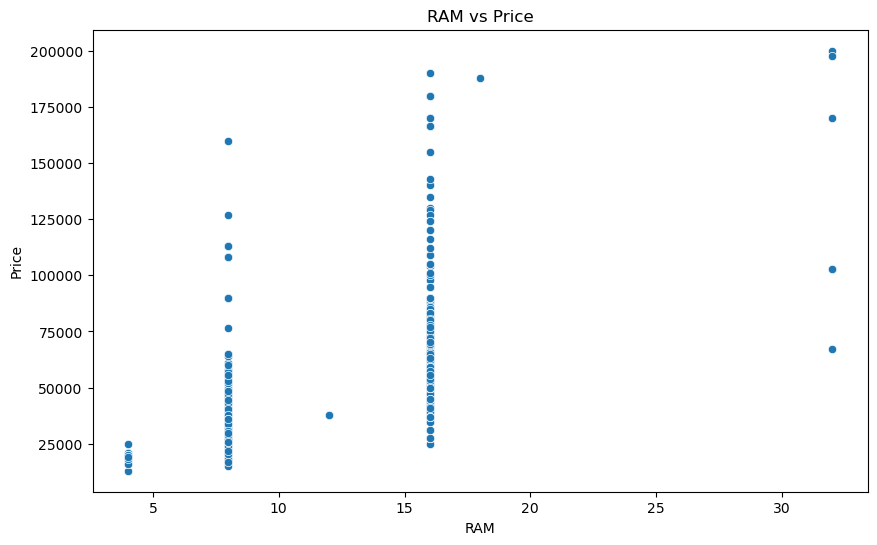

In [62]:
# Relationship between RAM and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RAM', y='Price', data=df)
plt.title('RAM vs Price')
plt.show()

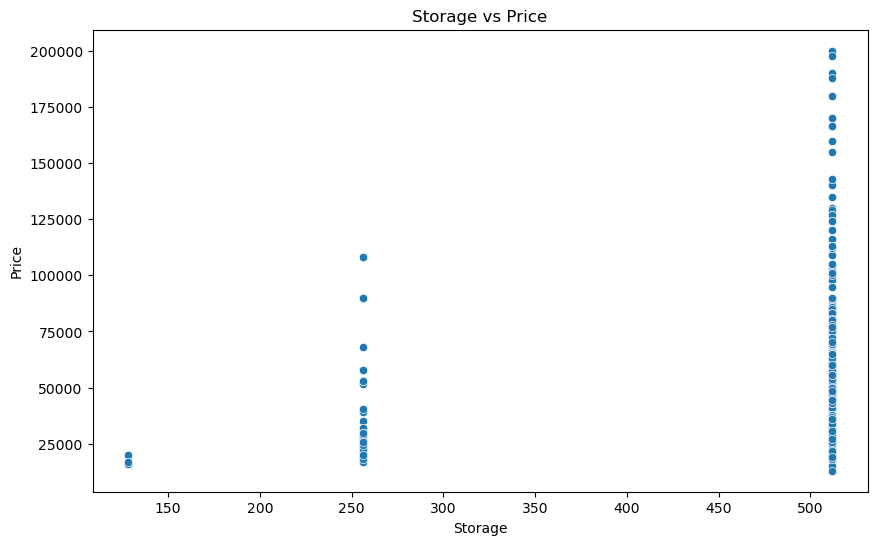

In [63]:
# Relationship between Storage and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Storage', y='Price', data=df)
plt.title('Storage vs Price')
plt.show()

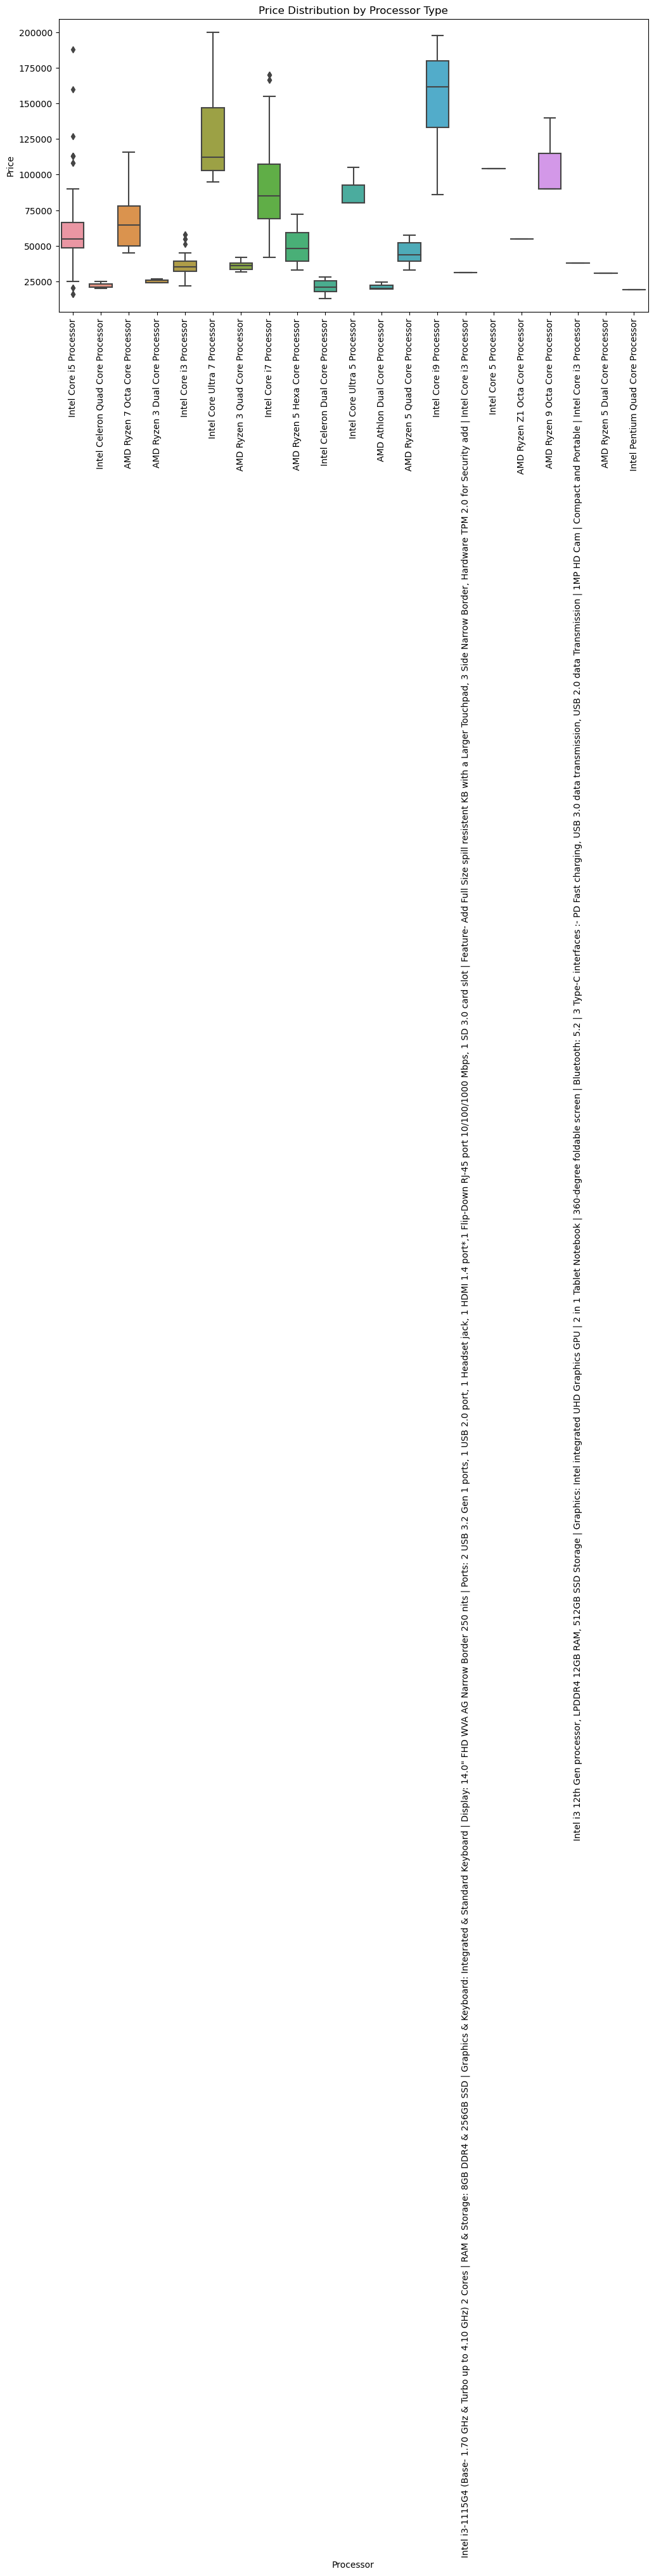

In [64]:
# Box plot of Price by Processor type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Processor', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Price Distribution by Processor Type')
plt.show()

# Statistical Insights

In [65]:
print("5. Statistical Insights:")
print(f"Average laptop price: ₹{df['Price'].mean():.2f}")
print(f"Median laptop price: ₹{df['Price'].median():.2f}")
print(f"Most common RAM size: {df['RAM'].mode().values[0]} GB")
print(f"Most common storage size: {df['Storage'].mode().values[0]} GB")
print(f"Correlation between RAM and Price: {df['RAM'].corr(df['Price']):.2f}")
print(f"Correlation between Storage and Price: {df['Storage'].corr(df['Price']):.2f}")

5. Statistical Insights:
Average laptop price: ₹55733.99
Median laptop price: ₹49990.00
Most common RAM size: 16 GB
Most common storage size: 512.0 GB
Correlation between RAM and Price: 0.58
Correlation between Storage and Price: 0.23


# Model Training and Optimization

In [66]:
# Prepare the features and target
features = ['RAM', 'Storage',  'Warranty']
X = df[features]
y = df['Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [67]:

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n6. Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': abs(model.coef_)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


6. Model Performance:
Mean Squared Error: 434675762.57
R-squared Score: 0.45

Feature Importance:
    Feature    Importance
0       RAM  14473.820166
2  Warranty  11627.368283
1   Storage   3741.753467


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [69]:
# Prepare the features and target
features = ['RAM', 'Storage',  'Warranty']
X = df[features]
y = df['Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [70]:
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    return np.mean(rmse_scores), np.std(rmse_scores)

In [71]:
# Initial Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_rmse, rf_std = evaluate_model(rf_model, X_train_scaled, y_train)
print(f"Random Forest - Initial RMSE: {rf_rmse:.2f} (+/- {rf_std:.2f})")

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

# Best Random Forest Model
best_rf_model = rf_grid_search.best_estimator_
rf_pred = best_rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest - Best Model Performance:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"R-squared Score: {rf_r2:.2f}")

Random Forest - Initial RMSE: 23194.24 (+/- 3634.31)
Random Forest - Best Model Performance:
Mean Squared Error: 385608475.12
R-squared Score: 0.52


In [72]:
# Initial XGBoost Model
xgb_model = XGBRegressor(random_state=42)
xgb_rmse, xgb_std = evaluate_model(xgb_model, X_train_scaled, y_train)
print(f"XGBoost - Initial RMSE: {xgb_rmse:.2f} (+/- {xgb_std:.2f})")

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train_scaled, y_train)

# Best XGBoost Model
best_xgb_model = xgb_grid_search.best_estimator_
xgb_pred = best_xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost - Best Model Performance:")
print(f"Mean Squared Error: {xgb_mse:.2f}")
print(f"R-squared Score: {xgb_r2:.2f}")

XGBoost - Initial RMSE: 23312.53 (+/- 3697.55)
XGBoost - Best Model Performance:
Mean Squared Error: 394844072.56
R-squared Score: 0.50


In [73]:
# Initial SVR Model
svr_model = SVR()
svr_rmse, svr_std = evaluate_model(svr_model, X_train_scaled, y_train)
print(f"SVR - Initial RMSE: {svr_rmse:.2f} (+/- {svr_std:.2f})")

# Hyperparameter tuning for SVR
svr_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid_search.fit(X_train_scaled, y_train)

# Best SVR Model
best_svr_model = svr_grid_search.best_estimator_
svr_pred = best_svr_model.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

print("SVR - Best Model Performance:")
print(f"Mean Squared Error: {svr_mse:.2f}")
print(f"R-squared Score: {svr_r2:.2f}")

SVR - Initial RMSE: 31202.65 (+/- 6734.13)
SVR - Best Model Performance:
Mean Squared Error: 714249951.89
R-squared Score: 0.10


In [76]:
models = {
    'Random Forest': (best_rf_model, rf_mse, rf_r2),
    'XGBoost': (best_xgb_model, xgb_mse, xgb_r2),
    'SVR': (best_svr_model, svr_mse, svr_r2)
}

best_model_name = min(models, key=lambda x: models[x][1])
best_model, best_mse, best_r2 = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Mean Squared Error: {best_mse:.2f}")
print(f"Best R-squared Score: {best_r2:.2f}")

# Feature Importance for the best model (if applicable)
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)


Best Model: Random Forest
Best Mean Squared Error: 385608475.12
Best R-squared Score: 0.52

Feature Importance:
    Feature  Importance
0       RAM    0.647823
2  Warranty    0.291719
1   Storage    0.060458


# "The trained Random Forest model 
utilizing data scraped from HTML content achieves a mean squared error of 385,608,475.12 and an R-squared score of 0.52, indicating moderate predictive power for laptop pricing based on RAM and warranty features."


# This sentence highlights the following aspects:


# Model Type: Random Forest
Data Source: Scraped HTML content
Metrics: Mean Squared Error (MSE) and R-squared score
Interpretation: Moderate predictive power for laptop pricing based on RAM and warranty.
Explanation of Metrics:


# Mean Squared Error (MSE):
While the absolute MSE value might be high, it depends on the scale of the target variable (price). Evaluating it relative to training data or normalizing the target variable is often helpful.
R-squared Score (R^2): A value of 0.52 indicates the model explains around 52% of the variance in laptop prices based on the chosen features.